In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import scipy as sci
import scipy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
#from matplotlib.colors import BASE_COLORS as palette
from matplotlib.colors import BASE_COLORS as mcolors
import sympy as sy
from sympy import diff

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#initialize mass values
#work in R2
G = 6.6743e-11
m0 = 10
m1,m3 = 10,10
m2,m4 = 10,10
M = m0 + 2*(m1 +m2) #total mass
c = 0

#once you pass the szehebely constant, you reach topological stability
#transform from velocity to momentum 
#convert your velocity vectors to momenta
#alpha1 and beta1, betas are zero in the initial configuration
#kasi for velocity values are initially zero
#not bold values in the paper are the norms of your velocity vectors
#intialize position vectors
#possible regularization in order to prevent numerical collisions
#choose velocities so that net velocity is downward
#also dependent upon velocities, and initial positions
#always solving an initial value problems for ODE
#check with different initial positions
#setting up a shooting method
#try to only vary the last downward initial velocity, v1, make it a negative velocity
#because of symmetry, it's similar to a three body problem, focus on that
#central mass has 0 velocity
#central masses stabalize objects going around them 
#can adjust the kinetic portion of your hamiltonian with a linear sympletic change of variable 
#track down info in order to calculate angular momentum for the given 5 body problem 
#orbits will define if our szchebely constant is correct or not, dependent on possible transitions 
#calculate the actual gravitational constant for newtonian mechanics 


r0 = np.array([0,0,0])
r1 = np.array([10,0,0])
r2 = np.array([5,0,0])
r3 = -r1
r4 = -r2

#initialize velocity vectors
rdot0 = np.array([0,0,0])
rdot1 = np.array([10,20,30])
rdot2 = np.array([10,20,30])
rdot3 = -rdot1
rdot4 = -rdot2

#intialize energy and hamiltonian
T = m1*rdot1**2 + m2*rdot2**2 #kinetic energy
I = 2*(m1*r1**2 + m2*r2**2) #moment of inertia
U = (2*m0*(m1/r1 + m2/r2) + (m1**2/r1 + m2**2/r2)/2 + 2*m1*m2*(1/abs(r1 - r2) + 1/np.sqrt(2*(r1**2 + r2**2) - abs(r1 - r2)**2))) #force potential function
H = T- U
E0 = -H
C0 = (c**2*E0)/(G**2 * M**5)



#hamiltonian will drift if close to collisions, should be constant along the solution


/var/folders/9t/wltz5rw540dg7_k5xs930j_c0000gn/T/ipykernel_58625/2031962531.py:49: RuntimeWarning: divide by zero encountered in true_divide
  U = (2*m0*(m1/r1 + m2/r2) + (m1**2/r1 + m2**2/r2)/2 + 2*m1*m2*(1/abs(r1 - r2) + 1/np.sqrt(2*(r1**2 + r2**2) - abs(r1 - r2)**2))) #force potential function
/var/folders/9t/wltz5rw540dg7_k5xs930j_c0000gn/T/ipykernel_58625/2031962531.py:52: RuntimeWarning: invalid value encountered in multiply
  C0 = (c**2*E0)/(G**2 * M**5)


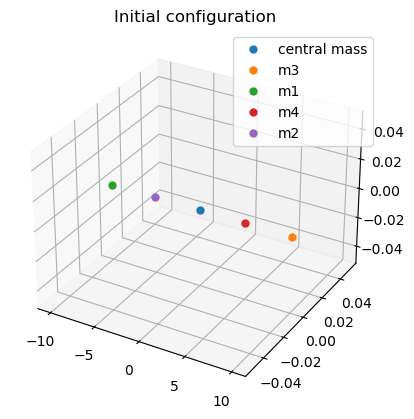

In [3]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot(0,0,0,'o',markersize = 5, label = 'central mass')
ax.plot(r1[0],r1[1],r1[2], 'o', markersize = 5, label = 'm3')
ax.plot(r3[0],r3[1],r3[2], 'o', markersize = 5, label = 'm1')
ax.plot(r2[0],r2[1],r2[2], 'o', markersize = 5, label = 'm4')
ax.plot(r4[0],r4[1],r4[2], 'o', markersize = 5, label = 'm2')
ax.legend(loc = 'upper right')
ax.set_title('Initial configuration')
#define the time step
dt = 0.01
n = 1000 #number of iterations

Text(0.5, 0.92, 'Coplanar for t>0')

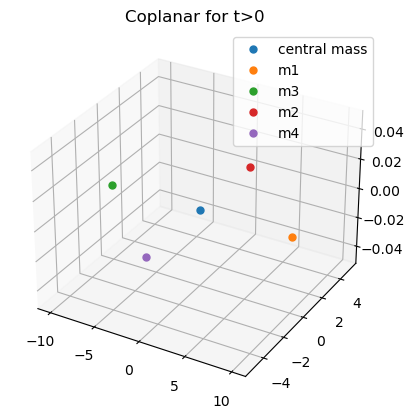

In [4]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot(0,0,0,'o',markersize = 5, label = 'central mass')
ax.plot(r1[0],r1[1],r1[2], 'o', markersize = 5, label = 'm1')
ax.plot(r3[0], r3[1],r3[2], 'o', markersize = 5, label = 'm3')
ax.plot(r2[1],r2[0],r2[2], 'o', markersize = 5, label = 'm2')
ax.plot(r4[1],r4[0],r4[2], 'o', markersize = 5, label = 'm4')

ax.legend(loc = 'upper right')
ax.set_title('Coplanar for t>0')

In [5]:
def equations_of_motion(params, t, G, m1, m2):
    #differentiate your hamiltonian with respect to a1, b1, a2, b2, kasi1, kasi2, eta1, eta2
    #use these as your differential equations and pass these into your solver
    #then plot those positions
    m0 = m1
    
    α1, β1, α2,β2, ξ1, ξ2, η1, η2 = sy.symbols('α1, β1, α2, β2, ξ1, ξ2, η1, η2')
    T = (1/(4*m1))*(ξ1**2 + η1**2) + (1/(4*m2))*(ξ2**2 + η2**2)
    U = 2*m0*m1/(α1**2 + β1**2)**(1/2) + 2*m0*m2/(α2**2 + β2**2)**(1/2) + m1**2/(2*(α1**2 + β1**2)**(1/2)) +m2**2/(2*(α2**2 + β2**2)**(1/2)) + (2*m1*m2)/((α1 - α2)**2 + (β1 - β2)**2)**(1/2) + (m1*m2)/((α1 + α2)**2 + (β1 + β2)**2)**(1/2)
    
    H = T-U
    
    ode1 = sy.diff(H, ξ1)
    ode2 = sy.diff(H, η1)
    ode3 = sy.diff(H, ξ2)
    ode4 = sy.diff(H, η2)
    ode5 = -sy.diff(H, α1)
    ode6 = -sy.diff(H, β1)
    ode7 = -sy.diff(H, α2)
    ode8 = -sy.diff(H, β2)
    
    ode1 = sy.lambdify(ξ1, ode1)
    ode2 = sy.lambdify(η1, ode2)
    ode3 = sy.lambdify(ξ2, ode3)
    ode4 = sy.lambdify(η2, ode4)
    ode5 = sy.lambdify([α1,β1,α2, β2], ode5)
    ode6 = sy.lambdify([α1,β1,α2, β2], ode6)
    ode7 = sy.lambdify([α1,β1,α2, β2], ode7)
    ode8 = sy.lambdify([α1,β1,α2, β2], ode8)
    
    
    #kasi 1, eta1, kasi 2, eta2 are modeling the movement of the 2 moving objects, 
    motions = []
    r2= params[0:2]
    a1_0,b1_0 = r2[0],r2[1]
    r3= params[2:4]
    a2_0,b2_0 = r3[0],r3[1] 
    position = np.array([r1,r2,r3,-r2,-r3],dtype = 'object')
    
    v2= params[4:6]
    kasi1_0, eta1_0 = v2[0],v2[1]
    
    v3= params[6:8]
    kasi2_0, eta2_0 = v3[0],v3[1]
    mass = np.array([m0,m1,m2,m1,m2])
    
    values = [ode1(kasi1_0),ode2(eta1_0),ode3(kasi2_0),ode4(eta2_0),ode5(a1_0,b1_0,a2_0,b2_0),ode6(a1_0,b1_0,a2_0,b2_0),ode7(a1_0,b1_0,a2_0,b2_0),ode8(a1_0,b1_0,a2_0,b2_0)]
    derivs = np.array(values)
    
    return derivs

In [7]:
def five_body_problem(p0,p1,p2,v1,v2,m0,m1,m2, dt, t_max):
    #need 8 first order differential equations for odeint
    #for each variable
    #find hamiltonian and then differentiate your hamiltonian with respect to the variables defined above
    
    """create the symmetrical 3 body problem
    parameters:
    center mass: m0
    m1,m2: masses of 2 bodies
    p0,p1,p2: positiions of first 2 vectors
    dt: time step
    t_max: number of time iterations"""
    #define hamiltonian functions
    α1, β1, α2,β2, ξ1, ξ2, η1, η2 = sy.symbols('α1, β1, α2, β2, ξ1, ξ2, η1, η2')
    T = (1/(4*m1))*(ξ1**2 + η1**2) + (1/(4*m2))*(ξ2**2 + η2**2)
    U = 2*m0*m1/(α1**2 + β1**2)**(1/2) + 2*m0*m2/(α2**2 + β2**2)**(1/2) + m1**2/(2*(α1**2 + β1**2)**(1/2)) +m2**2/(2*(α2**2 + β2**2)**(1/2)) + (2*m1*m2)/((α1 - α2)**2 + (β1 - β2)**2)**(1/2) + (m1*m2)/((α1 + α2)**2 + (β1 + β2)**2)**(1/2)

    H = sy.lambdify([α1, β1, α2, β2, ξ1, ξ2, η1, η2], T-U)
    E0 = -H(p1[0],p1[1],p2[0],p2[1],v1[0],v1[1],v2[0],v2[1])
    #define your time
    t =  np.linspace(0,t_max, int(t_max/dt))
    
    #define your 4th and 5th bodies position and mass
    p3 = -p1
    p4 = -p2
    m3 = m1
    m4 = m2
    
    #define your other 3 velocities
    v0 = np.array([0,0])
    v3 = -v1
    v4 = -v2
    
    #redefine your velocities as momentum
    q1,q2,q3,q4 = m1*v1, m2*v2, m3*v3, m4*v4
    
    #define your total mass
    M = m0 + 2*(m1 + m2)
    
    #define total angular momentum
    c = 2*m1*np.cross(p1,v1) + 2*m2*np.cross(p2,v2)
    
    #create mass and position arrays and define U, force potential function
    mass = np.array([m0,m1,m2,m3,m4])
    position = np.array([p0,p1,p2,p3,p4])
    
    position1 = np.array([p1 for i in range(t_max)])
    position2 = np.array([p2 for i in range(t_max)])
    position3 = -position1
    position4 = -position2
    
    #calculate necessary constants
    C0 = (c**2 * E0)/(M**5)
    
    
    init_params = np.array([p1,p2,v1,v2])
    init_params = init_params.flatten()
    
    solve = odeint(equations_of_motion, init_params, t, args = (G,m1,m2))
    
    r0_sol = p0
    r1_sol = solve[:, 0:2]
    r2_sol = solve[:, 2:4]
    r3_sol = -r1_sol
    r4_sol = -r2_sol
    
    x1 = r1_sol[:,0]
    x2 = r2_sol[:,0]
    y1 = r1_sol[:,1]
    y2 = r2_sol[:,1]
    
    plt.plot(r0_sol[0], r0_sol[1], 'o', color = 'fuchsia')
    plt.plot(r1_sol[:,0], r1_sol[:,1], color = 'springgreen', label = 'Mass 1')
    plt.plot(r2_sol[:,0], r2_sol[:,1], color = 'royalblue', label = 'Mass 2')
    plt.plot(r3_sol[:,0], r3_sol[:,1], color = 'crimson', label = 'Mass 3')
    plt.plot(r4_sol[:,0], r4_sol[:,1], color = 'darkorchid', label = 'Mass 4')
    
    plt.legend(loc = 'upper right')

    plt.show()
    
    return C0
    


            
    
    
    
        

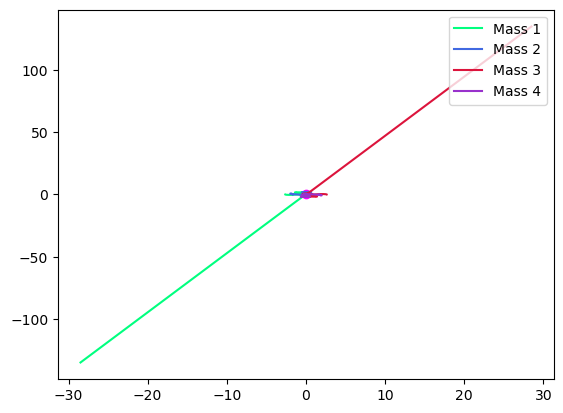

2.3944062360886714e-13

In [14]:
p0 = np.array([0,0])
p1 = np.array([-2.61,0])
p2 = np.array([-1.67,0])
v1 = np.array([0.15,-1.2])
v2 = np.array([0,1.981])
m0 = 1000
m1 = 1
m2 = 1
dt = 0.01
t_max = 100
five_body_problem(p0,p1,p2,v1,v2,m0,m1,m2,dt,t_max)

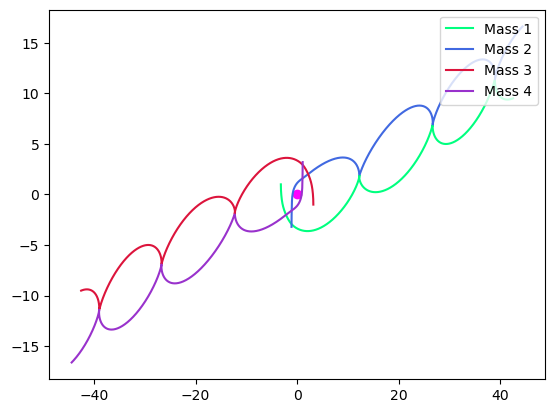

4.794271422605908e-08

In [15]:
p0 = np.array([0,0])
p1 = np.array([-3.2,1])
p2 = np.array([-1.1,-3.2])
v1 = np.array([0,-2.01])
v2 = np.array([0,2])
m0 = 200
m1 = 1
m2 = 1
dt = 0.01
t_max = 15
five_body_problem(p0,p1,p2,v1,v2,m0,m1,m2,dt,t_max)

In [12]:
#Define universal gravitation constant
G=6.67408e-11 #N-m2/kg2
#Reference quantities
m_nd=1.989e+30 #kg #mass of the sun
r_nd=5.326e+12 #m #distance between stars in Alpha Centauri
v_nd=30000 #m/s #relative velocity of earth around the sun
t_nd=79.91*365*24*3600*0.51 #s #orbital period of Alpha Centauri
#Net constants
K1=G*t_nd*m_nd/(r_nd**2*v_nd)
K2=v_nd*t_nd/r_nd

In [13]:
m1=1.1 #Alpha Centauri A
m2=0.907 #Alpha Centauri B
#Define initial position vectors
r1=[-0.5,0,0] #m
r2=[0.5,0,0] #m
#Convert pos vectors to arrays
r1=np.array(r1,dtype="float64")
r2=np.array(r2,dtype="float64")
#Find Centre of Mass
r_com=(m1*r1+m2*r2)/(m1+m2)
#Define initial velocities
v1=[0.01,0.01,0] #m/s
v2=[-0.05,0,-0.1] #m/s
#Convert velocity vectors to arrays
v1=np.array(v1,dtype="float64")
v2=np.array(v2,dtype="float64")
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

In [14]:
def TwoBodyEquations(w,t,G,m1,m2):
    r1=w[:3]
    r2=w[3:6]
    v1=w[6:9]
    v2=w[9:12]
    r=sci.linalg.norm(r2-r1) #Calculate magnitude or norm of vector
    dv1bydt=K1*m2*(r2-r1)/r**3
    dv2bydt=K1*m1*(r1-r2)/r**3
    dr1bydt=K2*v1
    dr2bydt=K2*v2
    r_derivs=np.concatenate((dr1bydt,dr2bydt))
    derivs= np.concatenate((r_derivs,dv1bydt,dv2bydt))
    return derivs

In [15]:
#Package initial parameters
init_params=np.array([r1,r2,v1,v2]) #create array of initial params
init_params=init_params.flatten() #flatten array to make it 1D
time_span=np.linspace(0,8,500) #8 orbital periods and 500 points
#Run the ODE solver
import scipy.integrate
two_body_sol=sci.integrate.odeint(TwoBodyEquations,init_params,time_span,args=(G,m1,m2))
print(two_body_sol.shape)
r1_sol=two_body_sol[:,:3]
print(r1_sol.shape)
r2_sol=two_body_sol[:,3:6]

(500, 12)
(500, 3)


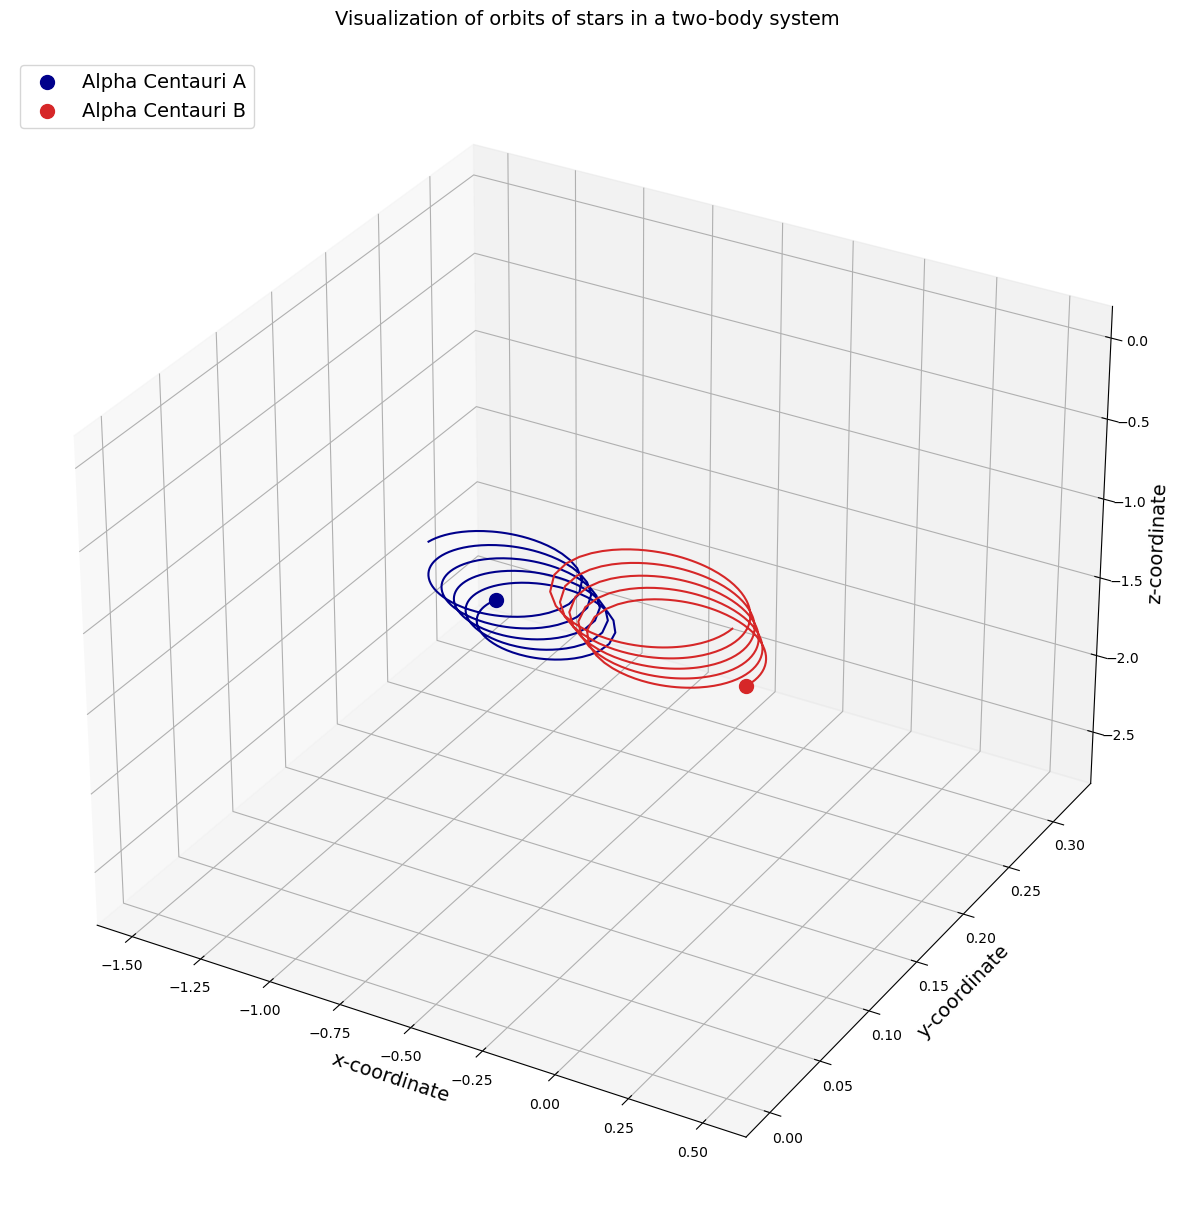

In [16]:
#Create figure
fig=plt.figure(figsize=(15,15))
#Create 3D axes
ax=fig.add_subplot(111,projection="3d")
#Plot the orbits
ax.plot(r1_sol[:,0],r1_sol[:,1],r1_sol[:,2],color="darkblue")
ax.plot(r2_sol[:,0],r2_sol[:,1],r2_sol[:,2],color="tab:red")
#Plot the final positions of the stars
ax.scatter(r1_sol[-1,0],r1_sol[-1,1],r1_sol[-1,2],color="darkblue",marker="o",s=100,label="Alpha Centauri A")
ax.scatter(r2_sol[-1,0],r2_sol[-1,1],r2_sol[-1,2],color="tab:red",marker="o",s=100,label="Alpha Centauri B")
#Add a few more bells and whistles
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Visualization of orbits of stars in a two-body system\n",fontsize=14)
ax.legend(loc="upper left",fontsize=14)